#Traditional and Deep Learning‑Based Image Processing for Fruit Quality and Rot Detection Using Public Datasets




# 1-Setup




## 1.1 Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 Install Required Packages

In [ ]:
# Install packages
!pip install -q kagglehub

## 1.3 Download Dataset from Kaggle

In [ ]:
import kagglehub

# Download the fruits dataset
kaggle_path = kagglehub.dataset_download("sriramr/fruits-fresh-and-rotten-for-classification")
print("kaggle path:", kaggle_path)

Using Colab cache for faster access to the 'fruits-fresh-and-rotten-for-classification' dataset.
kaggle path: /kaggle/input/fruits-fresh-and-rotten-for-classification


## 1.4 Import All Libraries

In [ ]:
#imporint modules and libs
import os
import time
import copy
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from itertools import product
import cv2
from skimage.feature import graycomatrix, graycoprops
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

# plots setup

sns.set_palette("husl")

#checking that we are working on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
# Set random seeds for reproducibility
import random
#fixing the seed for constant results
SEED = 45

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


Using device: cuda


## 1.5 Setup Data Paths

In [ ]:
DRIVE_TEST_DIR = "/content/drive/MyDrive/71254_2026/02_Assignment_Submission/omri.booton/projects/tests"
data_dir = os.path.join(kaggle_path, "dataset") if os.path.exists(os.path.join(kaggle_path, "dataset")) else kaggle_path
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

print(f"  Train dir: {train_dir}")
print(f"  Test dir:  {test_dir}")
print(f"  Drive test: {DRIVE_TEST_DIR}")
print(f"\n  Train classes: {os.listdir(train_dir)}")
print(f"  Test classes:  {os.listdir(test_dir)}")

  Train dir: /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train
  Test dir:  /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test
  Drive test: /content/drive/MyDrive/71254_2026/02_Assignment_Submission/omri.booton/projects/tests

  Train classes: ['rottenbanana', 'freshoranges', 'rottenoranges', 'freshbanana', 'rottenapples', 'freshapples']
  Test classes:  ['rottenbanana', 'freshoranges', 'rottenoranges', 'freshbanana', 'rottenapples', 'freshapples']


## 1.6 Visualize Sample Images

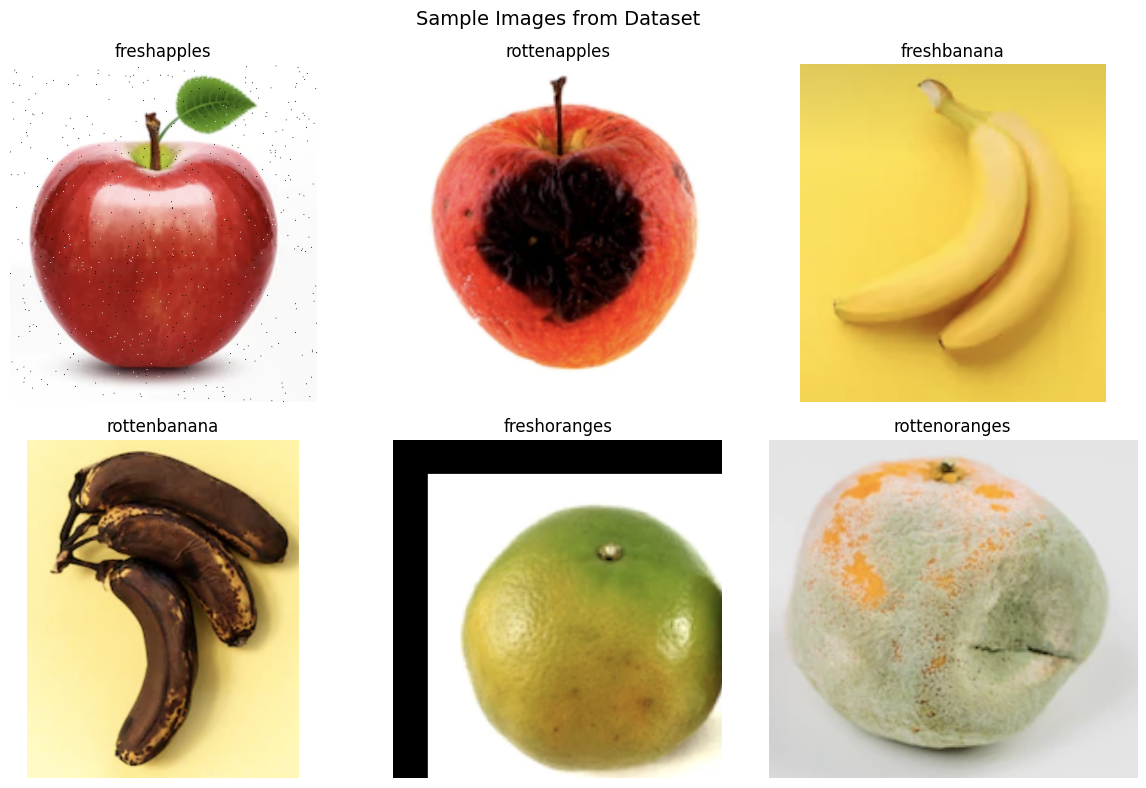

In [ ]:
# Display sample images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

sample_classes = ['freshapples', 'rottenapples', 'freshbanana',
                  'rottenbanana', 'freshoranges', 'rottenoranges']

for i, cls in enumerate(sample_classes[:6]):
    class_dir = os.path.join(train_dir, cls)
    if os.path.exists(class_dir):
        img_name = os.listdir(class_dir)[0]
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)

        ax = axes[i // 3, i %3]
        ax.imshow(img)
        ax.set_title(cls)
        ax.axis('off')

plt.suptitle('Sample Images from Dataset', fontsize=14)
plt.tight_layout()
plt.show()



#  2- Classical model




## 2.1 Segmentation Functions

Segmentation removes the background so features are computed only on fruit pixels. in this code chunk we are defining the functions to segment by seturation and otsu and then combine them

In [ ]:
def segment_by_saturation(img_rgb, sat_threshold=25):
    """    Simple and fast - works well when background is white/gray.
    Fruit has higher saturation than neutral backgrounds.
    """
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    mask = img_hsv[:, :, 1] > sat_threshold

    # Clean up mask with morphological operations
    kernel = np.ones((5, 5), np.uint8)
    mask = mask.astype(np.uint8) * 255
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # fill holes
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask > 0


def segment_by_otsu(img_rgb):
    """
    Automatic threshold selection using Otsu's method.
    Good for high contrast images.
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    t_value, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask > 0


def segment_combined(img_rgb):
    """
    Combined approach: saturation + value thresholding.
    Background: high value (bright) + low saturation (gray/white)
    Fruit: medium value + higher saturation (colorful)
    """
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    H, S, V = img_hsv[:, :, 0], img_hsv[:, :, 1], img_hsv[:, :, 2]

    # Fruit mask: has saturation AND not pure white background
    mask = (S > 20) & (V < 250)

    # Clean up
    kernel = np.ones((7, 7), np.uint8)
    mask = mask.astype(np.uint8) * 255
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Keep only largest connected component (the fruit)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(mask)
        cv2.drawContours(mask, [largest], -1, 255, -1)

    return mask > 0

## 2.2 Visualize Segmentation Methods
we are using the combination segmentation in the model, here we'll show a comparison to utso and saturation alone.

Fresh Apple Segmentation:


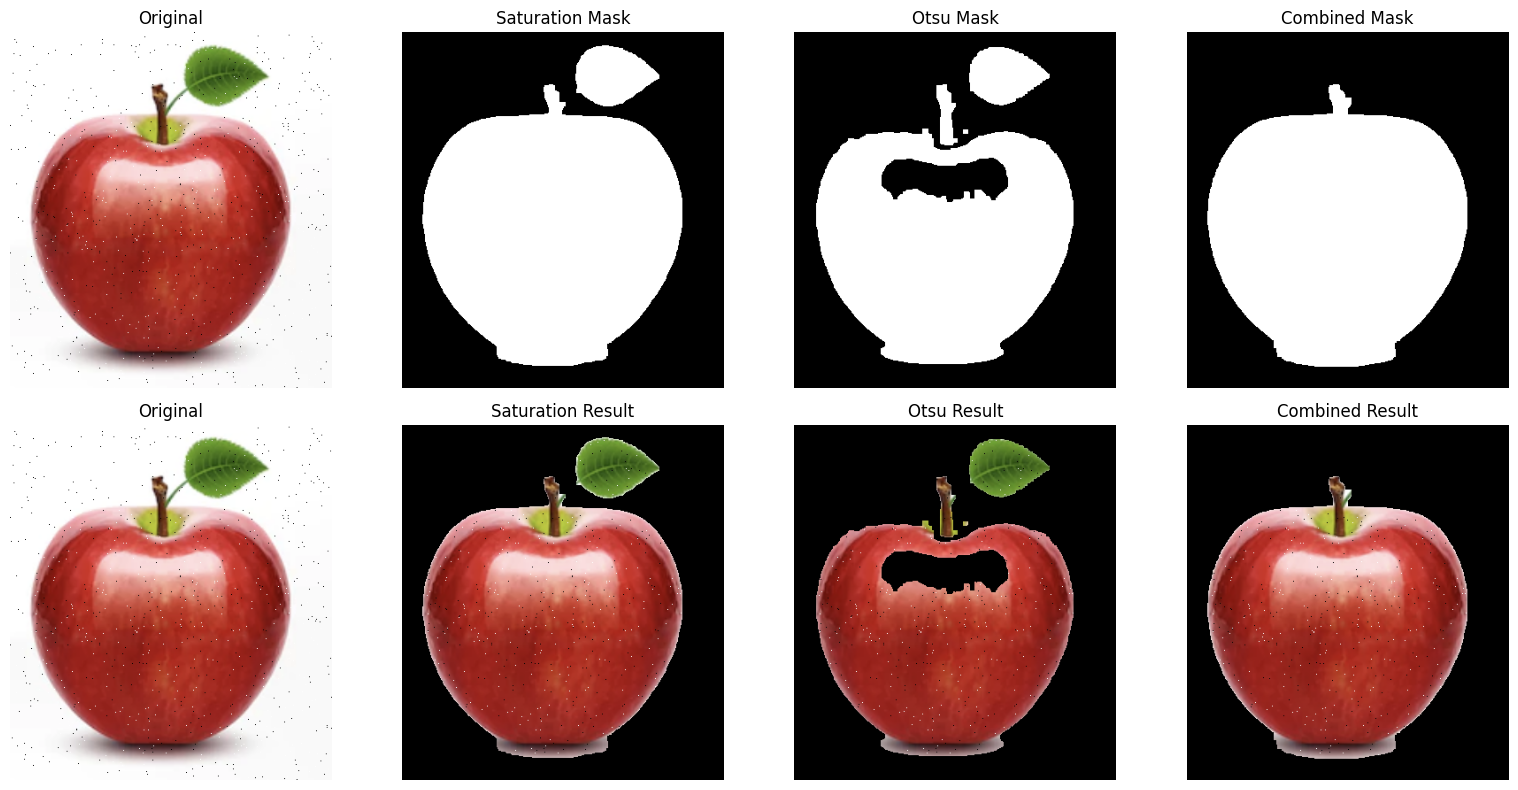

Rotten Apple Segmentation:


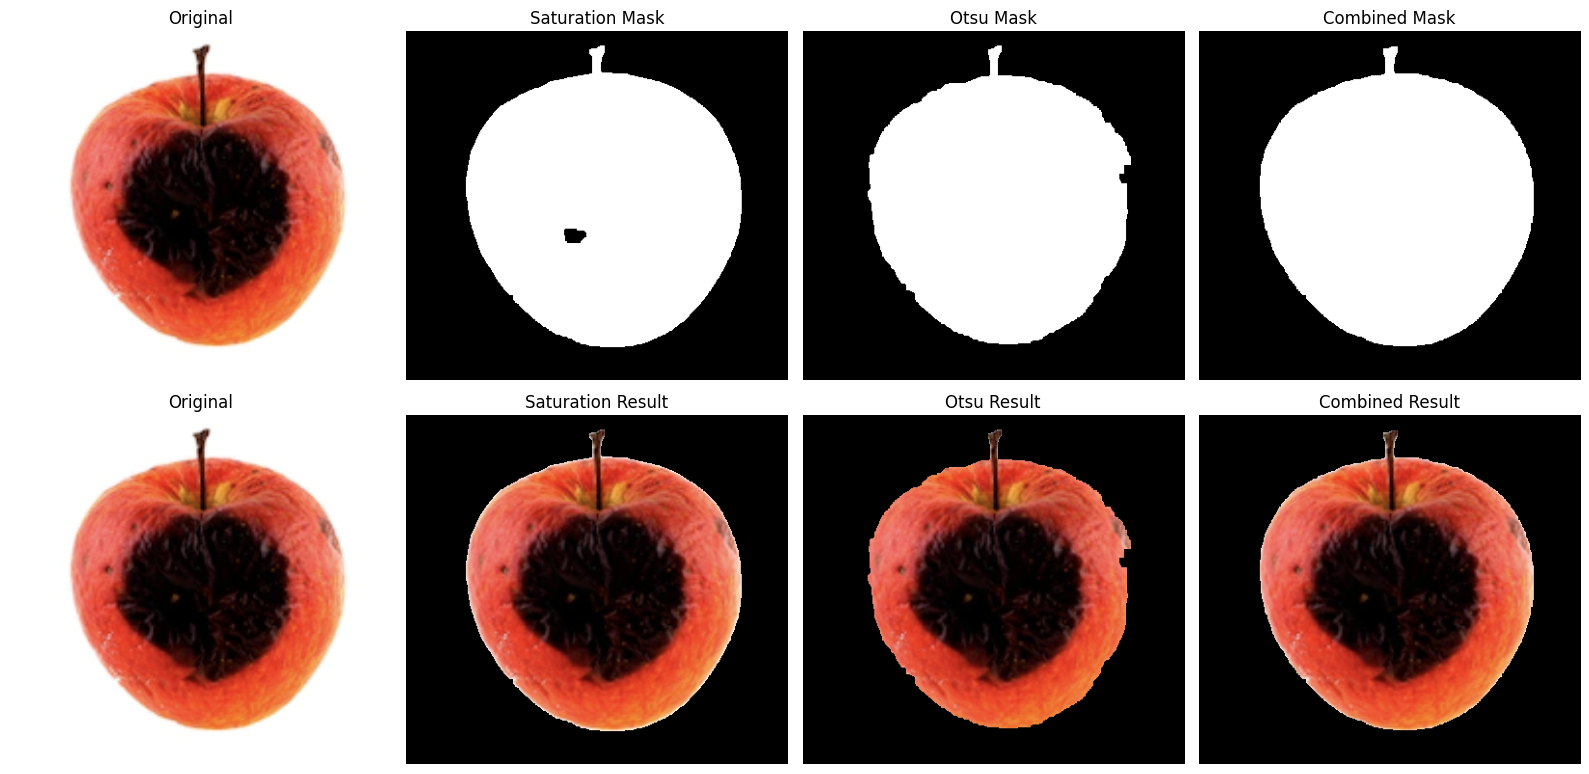

In [ ]:
# Visualize segmentation methods
def visualize_segmentation(img_path):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    mask_sat = segment_by_saturation(img_rgb)
    mask_otsu = segment_by_otsu(img_rgb)
    mask_combined = segment_combined(img_rgb)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Top row: masks
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('Original')
    axes[0, 1].imshow(mask_sat, cmap='gray')
    axes[0, 1].set_title('Saturation Mask')
    axes[0, 2].imshow(mask_otsu, cmap='gray')
    axes[0, 2].set_title('Otsu Mask')
    axes[0, 3].imshow(mask_combined, cmap='gray')
    axes[0, 3].set_title('Combined Mask')

    # Bottom row: applied masks
    axes[1, 0].imshow(img_rgb)
    axes[1, 0].set_title('Original')
    axes[1, 1].imshow(img_rgb * mask_sat[:, :, np.newaxis])
    axes[1, 1].set_title('Saturation Result')
    axes[1, 2].imshow(img_rgb * mask_otsu[:, :, np.newaxis])
    axes[1, 2].set_title('Otsu Result')
    axes[1, 3].imshow(img_rgb * mask_combined[:, :, np.newaxis])
    axes[1, 3].set_title('Combined Result')

    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Test on fresh and rotten samples
fresh_sample = os.path.join(train_dir, 'freshapples', os.listdir(os.path.join(train_dir, 'freshapples'))[0])
rotten_sample = os.path.join(train_dir, 'rottenapples', os.listdir(os.path.join(train_dir, 'rottenapples'))[0])

print("Fresh Apple Segmentation:")
visualize_segmentation(fresh_sample)

print("Rotten Apple Segmentation:")
visualize_segmentation(rotten_sample)

## 2.3 Feature Extraction

We extract **12 features** from each image:

| Category | Features |
|----------|----------|
| **Color (HSV)** | H_mean, H_std, S_mean, S_std, V_mean, V_std |
| **Texture (GLCM)** | contrast, homogeneity, energy, correlation |
| **Rot Indicators** | brown_ratio, dark_ratio |

In [ ]:
def extract_features_segmented(img_path, segmentation_method='combined'):
    """
    Extract features from ONLY the fruit region (not background).

    Args:
        img_path: path to image
        segmentation_method: 'saturation', 'otsu', or 'combined'

    Returns:
        feature vector (12 features)
    """
    # Load image
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise ValueError(f"Could not read image: {img_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Get segmentation mask
    mask = segment_combined(img_rgb)

    # using the original img if segmentation failed (mask too small, less than 50 pixels)
    if mask.sum() < (mask.size * 0.01):
        mask = np.ones(img_rgb.shape[:2], dtype=bool)

    # COLOR FEATURES (HSV)

    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    H_pixels = img_hsv[:, :, 0][mask]
    S_pixels = img_hsv[:, :, 1][mask]
    V_pixels = img_hsv[:, :, 2][mask]

    h_mean, h_std = H_pixels.mean(), H_pixels.std()
    s_mean, s_std = S_pixels.mean(), S_pixels.std()
    v_mean, v_std = V_pixels.mean(), V_pixels.std()

    # TEXTURE FEATURES (GLCM) - on grayscale

    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    gray_masked = gray.copy()
    gray_masked[~mask] = 0

    # Crop the image by mask for faster GLCM
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    if rows.any() and cols.any():
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        gray_crop = gray_masked[rmin:rmax+1, cmin:cmax+1]
    else:
        gray_crop = gray_masked

    gray_8 = gray_crop.astype(np.uint8)

    # GLCM with multiple angles for robust texture capture
    glcm = graycomatrix(
        gray_8,
        distances=[1, 3],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=256,
        symmetric=True,
        normed=True
    )

    contrast = graycoprops(glcm, 'contrast').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()

    # ROT-SPECIFIC FEATURES

    # Brown spot detection (rot is often brown)
    brown_mask = (
        (img_hsv[:, :, 0] >= 5) & (img_hsv[:, :, 0] <= 25) &
        (img_hsv[:, :, 2] < 150) &
        mask
    )
    brown_ratio = brown_mask.sum() / mask.sum() if mask.sum() > 0 else 0

    # Dark spot ratio
    dark_mask = (V_pixels < 80)
    dark_ratio = dark_mask.sum() / len(V_pixels) if len(V_pixels) > 0 else 0

    #FEATURE VECTOR

    features = np.array([
        h_mean, h_std,
        s_mean, s_std,
        v_mean, v_std,
        contrast,
        homogeneity,
        energy,
        correlation,
        brown_ratio,
        dark_ratio,
    ], dtype=np.float32)

    return features


# Feature names for reference
FEATURE_NAMES = [
    'H_mean', 'H_std', 'S_mean', 'S_std', 'V_mean', 'V_std',
    'Contrast', 'Homogeneity', 'Energy', 'Correlation',
    'Brown_ratio', 'Dark_ratio'
]

## 2.4 Data Loading Functions

In [ ]:
#Iterate over all images and returnes a tuple structure, as path and folder name
def iter_image_paths(base_dir):
    for cls in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, cls)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                yield os.path.join(class_dir, fname), cls

# load dataset and extract features with segmentation,Returns:
        #samples: numpy array of 12 features
        #labels: numpy array of labels (0=fresh, 1=rotten)
def load_dataset(base_dir, segmentation_method='combined'):
    samples = []
    labels = []
    count = 0

    print(f"Loading images from {base_dir}...")
    print(f"Using {segmentation_method} segmentation")

    for img_path, cls in iter_image_paths(base_dir):
      feats = extract_features_segmented(img_path, segmentation_method)
      samples.append(feats)
      label = 1 if "rotten" in cls.lower() else 0
      labels.append(label)
      #print every 500 images to let us know where we are
      count += 1
      if count % 500 == 0:
          print(f"  Processed {count} images...")

    samples = np.vstack(samples)
    labels = np.array(labels)

    print(f"\n Loaded {len(labels)} images")
    print(f"  Fresh: {(labels == 0).sum()}, Rotten: {(labels == 1).sum()}")

    return samples, labels

## 2.5 Load Training Data

In [ ]:
# Load training data
print(" LOADING TRAINING DATA")
train_samples, train_labels = load_dataset(train_dir, segmentation_method='combined')

 LOADING TRAINING DATA
Loading images from /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train...
Using combined segmentation
  Processed 500 images...
  Processed 1000 images...
  Processed 1500 images...
  Processed 2000 images...
  Processed 2500 images...
  Processed 3000 images...
  Processed 3500 images...
  Processed 4000 images...
  Processed 4500 images...
  Processed 5000 images...
  Processed 5500 images...
  Processed 6000 images...
  Processed 6500 images...
  Processed 7000 images...
  Processed 7500 images...
  Processed 8000 images...
  Processed 8500 images...
  Processed 9000 images...
  Processed 9500 images...
  Processed 10000 images...
  Processed 10500 images...

 Loaded 10901 images
  Fresh: 4740, Rotten: 6161


## 2.6 Load Test Data

In [ ]:
# Load test data
print(" LOADING TEST DATA")
test_samples, test_labels = load_dataset(test_dir, segmentation_method='combined')

 LOADING TEST DATA
Loading images from /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test...
Using combined segmentation
  Processed 500 images...
  Processed 1000 images...
  Processed 1500 images...
  Processed 2000 images...
  Processed 2500 images...

 Loaded 2698 images
  Fresh: 1164, Rotten: 1534


## 2.7 Feature Visualization

Compare feature distributions between fresh and rotten fruits.

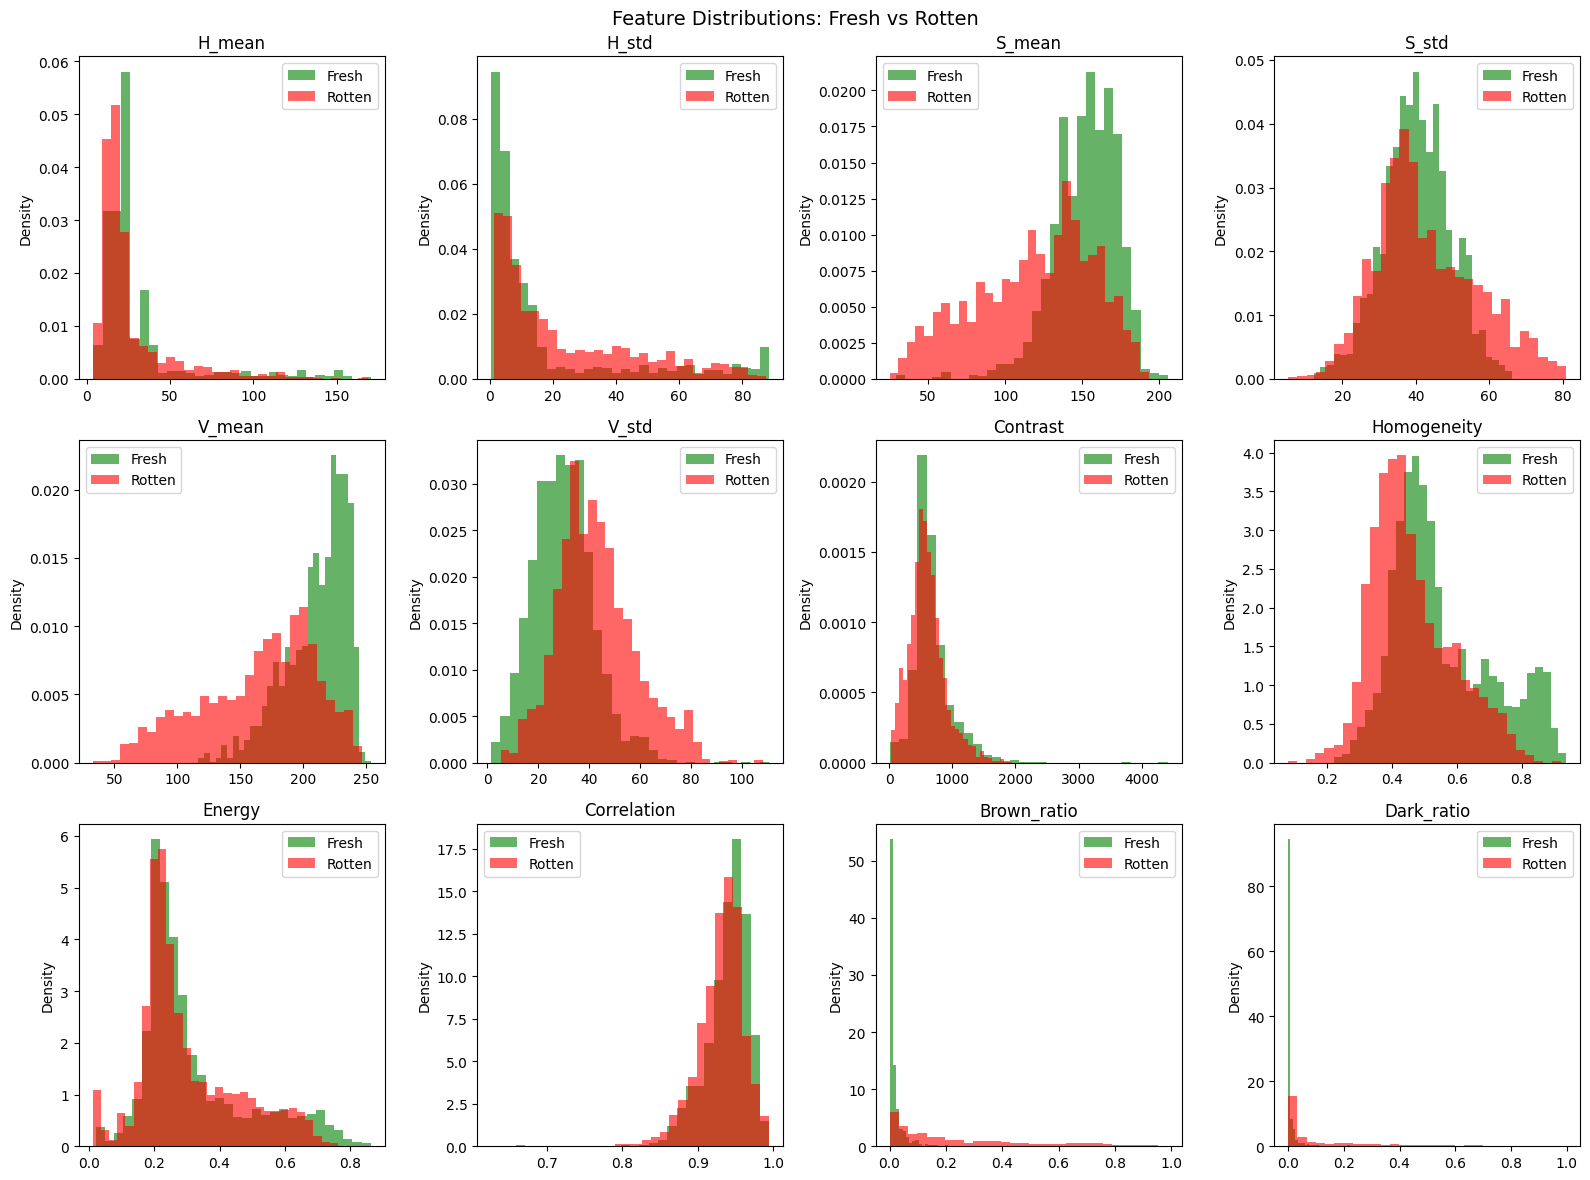

In [ ]:
def plot_feature_distributions(samples, labels, feature_names):
    fresh_samples = samples[labels == 0]
    rotten_samples = samples[labels == 1]

    n_features = samples.shape[1]
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for i in range(n_features):
        axes[i].hist(fresh_samples[:, i], bins=30, alpha=0.6,
                     label='Fresh', color='green', density=True)
        axes[i].hist(rotten_samples[:, i], bins=30, alpha=0.6,
                     label='Rotten', color='red', density=True)
        axes[i].set_title(feature_names[i])
        axes[i].legend()
        axes[i].set_ylabel('Density')

    plt.suptitle('Feature Distributions: Fresh vs Rotten', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_feature_distributions(train_samples, train_labels, FEATURE_NAMES)

## 2.8 Rule-Based Classifier

Classify using hand-crafted threshold rules on extracted features, resulting if fruit is rotten or not.
we decided to use only 8 of the 12 features, because we saw that using more or different didn't improve the results in many attemptes.

In [ ]:
#function to predict if fruit is rotten or fresh, score of 3 or more means its rotten.
def predict_rotten(features,
                   v_mean_thr=100,
                   s_mean_thr=70,
                   contrast_thr=150,
                   homogeneity_thr=0.5,
                   brown_ratio_thr=0.15,
                   dark_ratio_thr=0.2):

    (h_mean, h_std,
     s_mean, s_std,
     v_mean, v_std,
     contrast,
     homogeneity,
     energy,
     correlation,
     brown_ratio,
     dark_ratio) = features

    score = 0

    # Color-based indicators
    if v_mean < v_mean_thr:       # darker overall
        score += 1
    if s_mean < s_mean_thr:       # less saturated (faded)
        score += 1
    if h_std > 20:                # uneven color (spots)
        score += 1

    # Texture-based indicators
    if contrast > contrast_thr:    # rough texture
        score += 1
    if homogeneity < homogeneity_thr:  # irregular texture
        score += 1
    if energy < 0.1:              # less uniform
        score += 1

    # Rot-specific indicators (weighted higher)
    if brown_ratio > brown_ratio_thr:  # brown spots
        score += 2
    if dark_ratio > dark_ratio_thr:    # dark spots
        score += 2

    return 1 if score >= 3 else 0

## 2.9 Grid Search for Optimal Thresholds

Find the best threshold values by checking combinations.

In [ ]:
def grid_search(train_samples, train_labels):

    # Parameter ranges to search, ranging around parameters from last attempt
    v_mean_options = [80, 90, 100, 110, 120]
    s_mean_options = [50, 60, 70, 80, 90]
    contrast_options = [100, 150, 200, 250]
    hom_options = [0.3, 0.4, 0.5, 0.6]
    brown_options = [0.05, 0.10, 0.15, 0.20]
    dark_options = [0.10, 0.15, 0.20, 0.25]
#acc is accuracy= this our way to find the optimal combination
    best_acc = 0
    best_params = None

    total = (len(v_mean_options) * len(s_mean_options) *
             len(contrast_options) * len(hom_options) *
             len(brown_options) * len(dark_options))
    print(f"Testing {total} combinations...")

    tested = 0
    for v_thr, s_thr, c_thr, h_thr, b_thr, d_thr in product(
        v_mean_options, s_mean_options, contrast_options,
        hom_options, brown_options, dark_options
    ):
        preds = np.array([
            predict_rotten(f, v_thr, s_thr, c_thr, h_thr, b_thr, d_thr)
            for f in train_samples
        ])
        acc = (preds == train_labels).mean()

        if acc > best_acc:
            best_acc = acc
            best_params = (v_thr, s_thr, c_thr, h_thr, b_thr, d_thr)

        tested += 1
        if tested % 2000 == 0:
            print(f"  Progress: {tested}/{total}, Best so far: {best_acc*100:.2f}%")

    print(f"\n Best accuracy: {best_acc*100:.2f}%")
    print(f" Best parameters:")
    print(f"    v_mean_thr={best_params[0]}, s_mean_thr={best_params[1]}")
    print(f"    contrast_thr={best_params[2]}, homogeneity_thr={best_params[3]}")
    print(f"    brown_ratio_thr={best_params[4]}, dark_ratio_thr={best_params[5]}")

    return best_params, best_acc

## 2.10 Run Grid Search

In [ ]:
# Run grid search to find the parameters with best acc
best_params, best_train_acc = grid_search(train_samples, train_labels)

Testing 6400 combinations...
  Progress: 2000/6400, Best so far: 82.97%
  Progress: 4000/6400, Best so far: 82.97%
  Progress: 6000/6400, Best so far: 82.97%

 Best accuracy: 82.97%
 Best parameters:
    v_mean_thr=80, s_mean_thr=90
    contrast_thr=250, homogeneity_thr=0.4
    brown_ratio_thr=0.05, dark_ratio_thr=0.15


## 2.11 Evaluation Functions

In [ ]:
# returns Evaluate parameters for the model.
def evaluate_model(samples, labels, params):
    v_thr, s_thr, c_thr, h_thr, b_thr, d_thr = params

    preds = np.array([
        predict_rotten(f, v_thr, s_thr, c_thr, h_thr, b_thr, d_thr)
        for f in samples
    ])

    acc = (preds == labels).mean()

    tp = ((preds == 1) & (labels == 1)).sum()
    tn = ((preds == 0) & (labels == 0)).sum()
    fp = ((preds == 1) & (labels == 0)).sum()
    fn = ((preds == 0) & (labels == 1)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
        'predictions': preds
    }

#printing function
def print_results(results, title="Results"):
    print(f" {title}")
    #converting to precent and print
    print(f"  Accuracy:  {results['accuracy']*100:.2f}%")
    print(f"  Precision: {results['precision']*100:.2f}%")
    print(f"  Recall:    {results['recall']*100:.2f}%")
    print(f"  F1-Score:  {results['f1']*100:.2f}%")
    #printing with nice layouts
    print(f"\n  Confusion Matrix:")
    print(f"                  Predicted")
    print(f"                Fresh    Rotten")
    print(f"    Actual Fresh   {results['tn']:5d}    {results['fp']:5d}")
    print(f"    Actual Rotten  {results['fn']:5d}    {results['tp']:5d}")

## 2.12 Evaluate Classical Model

In [ ]:
# Evaluate on training set
train_results_classical = evaluate_model(train_samples, train_labels, best_params)
print_results(train_results_classical, "Classical Model - Training Set")

# Evaluate on test set
test_results_classical = evaluate_model(test_samples, test_labels, best_params)
print_results(test_results_classical, "Classical Model - Test Set")

 Classical Model - Training Set
  Accuracy:  82.97%
  Precision: 88.16%
  Recall:    80.72%
  F1-Score:  84.27%

  Confusion Matrix:
                  Predicted
                Fresh    Rotten
    Actual Fresh    4072      668
    Actual Rotten   1188     4973
 Classical Model - Test Set
  Accuracy:  82.17%
  Precision: 88.29%
  Recall:    79.14%
  F1-Score:  83.47%

  Confusion Matrix:
                  Predicted
                Fresh    Rotten
    Actual Fresh    1003      161
    Actual Rotten    320     1214


## 2.13 Per-Fruit Analysis Functions

In [ ]:
#Load dataset separated by fruit type
def load_dataset_by_fruit(base_dir, segmentation_method='combined'):
    fruits = {'apples': ([], []), 'bananas': ([], []), 'oranges': ([], [])}

    for img_path, cls in iter_image_paths(base_dir):
        cls_lower = cls.lower()
#doing it over by fruit types,"try" to avoide collapsing and droping the problematic img
        try:
            feats = extract_features_segmented(img_path, segmentation_method)
            label = 1 if "rotten" in cls_lower else 0

            if 'apple' in cls_lower:
                fruits['apples'][0].append(feats)
                fruits['apples'][1].append(label)
            elif 'banana' in cls_lower:
                fruits['bananas'][0].append(feats)
                fruits['bananas'][1].append(label)
            elif 'orange' in cls_lower:
                fruits['oranges'][0].append(feats)
                fruits['oranges'][1].append(label)
        except:
            continue

    # Convert to numpy
    for fruit in fruits:
        fruits[fruit] = (np.vstack(fruits[fruit][0]), np.array(fruits[fruit][1]))

    return fruits

# Load and evaluate per fruit
print("Loading test data by fruit type...")
test_by_fruit = load_dataset_by_fruit(test_dir)

print(" PER-FRUIT RESULTS (Classical Model)")


for fruit, (samples, labels) in test_by_fruit.items():
    results = evaluate_model(samples, labels, best_params)
    print(f"\n{fruit.upper()}:")
    print(f"  Samples: {len(labels)} (Fresh: {(labels==0).sum()}, Rotten: {(labels==1).sum()})")
    print(f"  Accuracy: {results['accuracy']*100:.2f}%")
    print(f"  F1-Score: {results['f1']*100:.2f}%")

Loading test data by fruit type...
 PER-FRUIT RESULTS (Classical Model)

APPLES:
  Samples: 996 (Fresh: 395, Rotten: 601)
  Accuracy: 80.02%
  F1-Score: 81.99%

BANANAS:
  Samples: 911 (Fresh: 381, Rotten: 530)
  Accuracy: 90.12%
  F1-Score: 92.08%

ORANGES:
  Samples: 791 (Fresh: 388, Rotten: 403)
  Accuracy: 75.73%
  F1-Score: 71.26%


## 2.14 Evaluate on Custom Drive Test Set

In [ ]:
!cp -r "/content/drive/MyDrive/71254_2026/02_Assignment_Submission/omri.booton/projects/tests" "/content/tests_local"
new_test_dir = "/content/tests_local"

# Load new test data with segmentation
new_test_samples, new_test_labels = load_dataset(new_test_dir, segmentation_method='combined')

# Evaluate with best parameters from grid search
new_test_results = evaluate_model(new_test_samples, new_test_labels, best_params)
print_results(new_test_results, "Classical Model - NEW TEST SET (Drive)")
drive_results_classical=new_test_results


Loading images from /content/tests_local...
Using combined segmentation
  Processed 500 images...
  Processed 1000 images...

 Loaded 1200 images
  Fresh: 600, Rotten: 600
 Classical Model - NEW TEST SET (Drive)
  Accuracy:  59.17%
  Precision: 58.79%
  Recall:    61.33%
  F1-Score:  60.03%

  Confusion Matrix:
                  Predicted
                Fresh    Rotten
    Actual Fresh     342      258
    Actual Rotten    232      368


##2.15 ploting general results

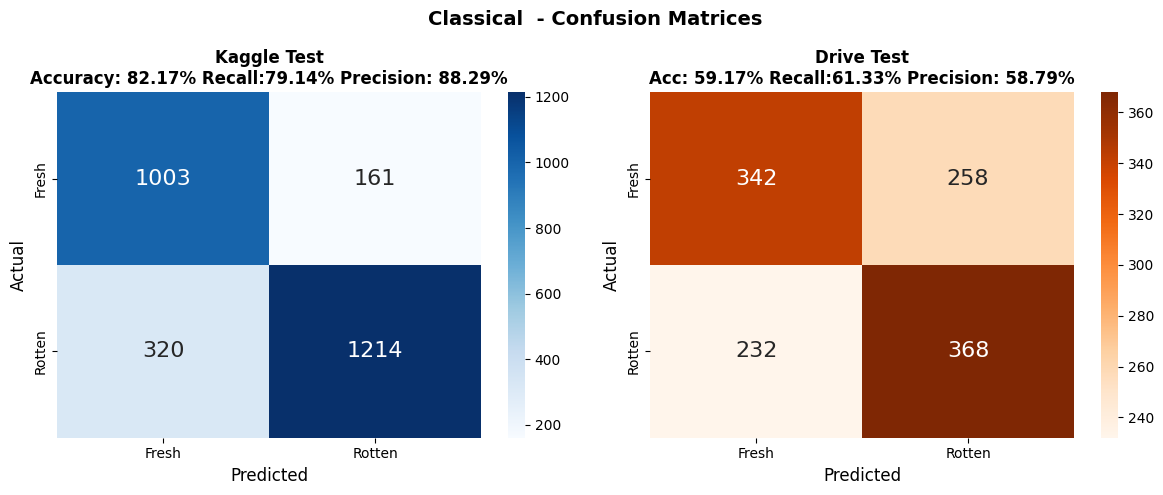

In [ ]:
# CONFUSION MATRICES HEATMAPS


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Kaggle confusion matrix
cm_kaggle = np.array([[test_results_classical['tn'], test_results_classical['fp']],
                      [test_results_classical['fn'], test_results_classical['tp']]])

sns.heatmap(cm_kaggle, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Fresh', 'Rotten'], yticklabels=['Fresh', 'Rotten'],
            annot_kws={'size': 16})
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title(f'Kaggle Test\nAccuracy: {test_results_classical["accuracy"]*100:.2f}% Recall:{test_results_classical["recall"]*100:.2f}% Precision: {test_results_classical["precision"]*100:.2f}%', fontweight='bold')

# Drive confusion matrix
cm_drive = np.array([[drive_results_classical['tn'], drive_results_classical['fp']],
                     [drive_results_classical['fn'], drive_results_classical['tp']]])

sns.heatmap(cm_drive, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Fresh', 'Rotten'], yticklabels=['Fresh', 'Rotten'],
            annot_kws={'size': 16})
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title(f'Drive Test\nAcc: {drive_results_classical["accuracy"]*100:.2f}% Recall:{drive_results_classical["recall"]*100:.2f}% Precision: {drive_results_classical["precision"]*100:.2f}%', fontweight='bold')

plt.suptitle('Classical  - Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2.16 Per-Fruit Comparison: Kaggle vs Drive Test

In [ ]:
# PER-FRUIT COMPARISON: KAGGLE TEST vs DRIVE TEST (Classical Model Only)

# LOAD PER FRUIT - KAGGLE TEST

kaggle_by_fruit = load_dataset_by_fruit(test_dir)


#  LOAD PER FRUIT - DRIVE TEST


print(" LOADING DRIVE TEST BY FRUIT")

drive_by_fruit = load_dataset_by_fruit(new_test_dir)

#  EVALUATE EACH FRUIT ON BOTH DATASETS
kaggle_results = {}
drive_results = {}

for fruit in ['apples', 'bananas', 'oranges']:
    # Kaggle
    if fruit in kaggle_by_fruit:
        samples, labels = kaggle_by_fruit[fruit]
        kaggle_results[fruit] = evaluate_model(samples, labels, best_params)
        kaggle_results[fruit]['samples'] = len(labels)
    # Drive
    if fruit in drive_by_fruit:
        samples, labels = drive_by_fruit[fruit]
        drive_results[fruit] = evaluate_model(samples, labels, best_params)
        drive_results[fruit]['samples'] = len(labels)


#  CREATE NICE COMPARISON TABLE


print(" PER-FRUIT COMPARISON: KAGGLE TEST vs DRIVE TEST")

rows = []
for fruit in ['apples', 'bananas', 'oranges']:
    if fruit in kaggle_results:
        k = kaggle_results[fruit]
        rows.append({
            'Fruit': fruit.capitalize(),
            'Dataset': 'Kaggle',
            'Samples': k['samples'],
            'Accuracy': f"{k['accuracy']*100:.2f}%",
            'Precision': f"{k['precision']*100:.2f}%",
            'Recall': f"{k['recall']*100:.2f}%",
            'F1': f"{k['f1']*100:.2f}%",
            'TP': k['tp'],
            'TN': k['tn'],
            'FP': k['fp'],
            'FN': k['fn']
        })

    if fruit in drive_results:
        d = drive_results[fruit]
        rows.append({
            'Fruit': fruit.capitalize(),
            'Dataset': 'Drive',
            'Samples': d['samples'],
            'Accuracy': f"{d['accuracy']*100:.2f}%",
            'Precision': f"{d['precision']*100:.2f}%",
            'Recall': f"{d['recall']*100:.2f}%",
            'F1': f"{d['f1']*100:.2f}%",
            'TP': d['tp'],
            'TN': d['tn'],
            'FP': d['fp'],
            'FN': d['fn']
        })

comparison_df = pd.DataFrame(rows)
print("\n" + comparison_df.to_string(index=False))

# 5. SUMMARY TABLE - SIDE BY SIDE
print("  SUMMARY: KAGGLE vs DRIVE (Side by Side)")
summary_rows = []
for fruit in ['apples', 'bananas', 'oranges']:
    row = {'Fruit': fruit.capitalize()}

    if fruit in kaggle_results:
        k = kaggle_results[fruit]
        row['Kaggle Acc'] = f"{k['accuracy']*100:.1f}%"
        row['Kaggle F1'] = f"{k['f1']*100:.1f}%"

    if fruit in drive_results:
        d = drive_results[fruit]
        row['Drive Acc'] = f"{d['accuracy']*100:.1f}%"
        row['Drive F1'] = f"{d['f1']*100:.1f}%"

        # Difference
        if fruit in kaggle_results:
            diff = (d['accuracy'] - k['accuracy']) * 100
            row['Diff'] = f"{diff:+.1f}%"

    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("\n" + summary_df.to_string(index=False))


 LOADING DRIVE TEST BY FRUIT
 PER-FRUIT COMPARISON: KAGGLE TEST vs DRIVE TEST

  Fruit Dataset  Samples Accuracy Precision Recall     F1  TP  TN  FP  FN
 Apples  Kaggle      996   80.02%    89.88% 75.37% 81.99% 453 344  51 148
 Apples   Drive      400   75.50%    78.02% 71.00% 74.35% 142 160  40  58
Bananas  Kaggle      911   90.12%    86.30% 98.68% 92.08% 523 298  83   7
Bananas   Drive      400   68.00%    61.18% 98.50% 75.48% 197  75 125   3
Oranges  Kaggle      791   75.73%    89.81% 59.06% 71.26% 238 361  27 165
Oranges   Drive      400   34.00%    23.77% 14.50% 18.01%  29 107  93 171
  SUMMARY: KAGGLE vs DRIVE (Side by Side)

  Fruit Kaggle Acc Kaggle F1 Drive Acc Drive F1   Diff
 Apples      80.0%     82.0%     75.5%    74.3%  -4.5%
Bananas      90.1%     92.1%     68.0%    75.5% -22.1%
Oranges      75.7%     71.3%     34.0%    18.0% -41.7%


'# 6. VISUAL COMPARISON\nfig, axes = plt.subplots(1, 2, figsize=(14, 5))\n\nfruits = [\'Apples\', \'Bananas\', \'Oranges\']\nx = np.arange(len(fruits))\nwidth = 0.35\n\n# Accuracy comparison\nkaggle_acc = [kaggle_results.get(f.lower(), {}).get(\'accuracy\', 0)*100 for f in fruits]\ndrive_acc = [drive_results.get(f.lower(), {}).get(\'accuracy\', 0)*100 for f in fruits]\n\nbars1 = axes[0].bar(x - width/2, kaggle_acc, width, label=\'Kaggle Test\', color=\'steelblue\')\nbars2 = axes[0].bar(x + width/2, drive_acc, width, label=\'Drive Test\', color=\'coral\')\n\naxes[0].set_ylabel(\'Accuracy (%)\')\naxes[0].set_title(\'Accuracy by Fruit\', fontweight=\'bold\')\naxes[0].set_xticks(x)\naxes[0].set_xticklabels(fruits)\naxes[0].legend()\naxes[0].set_ylim([0, 100])\naxes[0].grid(axis=\'y\', alpha=0.3)\n\nfor bar in bars1 + bars2:\n    height = bar.get_height()\n    axes[0].annotate(f\'{height:.1f}%\', xy=(bar.get_x() + bar.get_width()/2, height),\n                     xytext=(0, 3), textcoords="



# 3-CNN- ResNet-50 Transfer Learning (PyTorch) for classification

Now we use **deep learning** with a pre-trained ResNet-50 model:
- **Transfer Learning:** Use ImageNet pre-trained weights
- **Two-phase training:** First train head only, then fine-tune deeper layers
- **Comprehensive metrics:** Track Accuracy, Precision, Recall, F1, Confusion Matrix


## 3.1 ResNet-50 Parameters

In [ ]:
# RESNET-50 PARAMETERS
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_PHASE1 = 5   # Train head only
EPOCHS_PHASE2 = 5   # Fine-tune layer4 + head
VAL_SPLIT = 0.5     # Split Kaggle test: 50% validation, 50% test

## 3.2 Data Transforms & Custom Dataset

In [ ]:
#TRANSFORMS & CUSTOM DATASET

# Training transforms- seting img size and parameters to fit the model as traind, and givving more options for training to avoid over fitting
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Validation/Test transforms. no need for transformations
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Custom dataset: maps 6 folders (each fruit has 2) -> 2 labels (fresh=0, rotten=1)
class FreshRottenDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        path, _ = self.samples[index]
        img = self.loader(path)
        folder = os.path.basename(os.path.dirname(path)).lower()

        if "fresh" in folder:
            label = 0
        elif "rotten" in folder:
            label = 1
        else:
            raise ValueError(f"Unknown folder: {folder}")

        if self.transform:
            img = self.transform(img)

        return img, label

print("Transforms and dataset class defined")

Transforms and dataset class defined


## 3.3 Create Train / Validation / Test Splits

In [ ]:
#CREATE TRAIN / VALIDATION / TEST SPLITS
kaggle_test_dir=test_dir

train_dataset = FreshRottenDataset(train_dir, transform=train_transforms)

# Kaggle test folder -split 50/50 into validation and test
full_test_dataset = FreshRottenDataset(kaggle_test_dir, transform=val_transforms)
total_test = len(full_test_dataset)
val_size = int(total_test * VAL_SPLIT)
test_size = total_test - val_size

# Use random_split with generator to maintain the same split every epoch
generator = torch.Generator().manual_seed(SEED)
val_dataset, kaggle_test_dataset = random_split(full_test_dataset, [val_size, test_size], generator=generator)

print(" DATASET SPLITS")
print(f"  Training:        {len(train_dataset):,} images")
print(f"  Validation:      {len(val_dataset):,} images (50% of Kaggle test)")
print(f"  Kaggle Test:     {len(kaggle_test_dataset):,} images (50% of Kaggle test)")

 DATASET SPLITS
  Training:        10,901 images
  Validation:      1,349 images (50% of Kaggle test)
  Kaggle Test:     1,349 images (50% of Kaggle test)


## 3.4 Create Data Loaders

In [ ]:
#Create data load- feeding the model few images every epoch to avoide colapse
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
#no need for shuffle in val and test
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

kaggle_test_loader = DataLoader(
    kaggle_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(kaggle_test_loader)}")


DataLoaders created:
  Train batches: 341
  Val batches: 43
  Test batches: 43


## 3.5 Visualize Training Samples

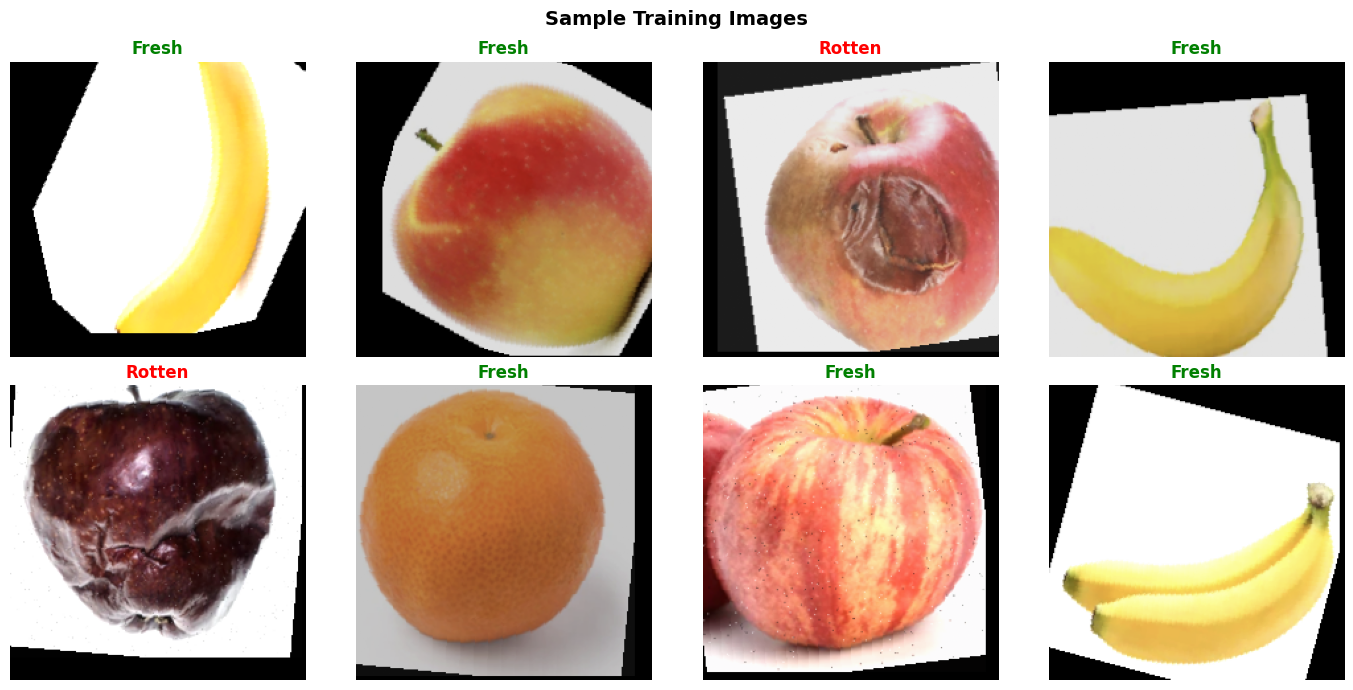

In [ ]:
#  VISUALIZE SAMPLE IMAGES
#Reverse ImageNet normalization for display
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Get a batch
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
class_names = ['Fresh', 'Rotten']

for i, ax in enumerate(axes.flat):
    if i < len(images):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"{class_names[labels[i].item()]}",
                     color='green' if labels[i]==0 else 'red',
                     fontsize=12, fontweight='bold')
    ax.axis('off')

plt.suptitle('Sample Training Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.6 Build ResNet-50 Model

In [ ]:

# BUILD RESNET-50 MODEL

# Load pretrained ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Move to device
model = model.to(device)

print(" MODEL ARCHITECTURE")
print(f"  Base: ResNet-50 (pretrained on ImageNet)")
print(f"  Modified FC: {num_features} -> 2 classes")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


 MODEL ARCHITECTURE
  Base: ResNet-50 (pretrained on ImageNet)
  Modified FC: 2048 -> 2 classes
  Total parameters: 23,512,130


## 3.7 Training Helper Functions

In [ ]:

#Calculate all classification metrics
def calculate_metrics(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion matrix elements
    TP = ((y_pred == 1) & (y_true == 1)).sum()
    TN = ((y_pred == 0) & (y_true == 0)).sum()
    FP = ((y_pred == 1) & (y_true == 0)).sum()
    FN = ((y_pred == 0) & (y_true == 1)).sum()

    # Metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'TP': int(TP),
        'TN': int(TN),
        'FP': int(FP),
        'FN': int(FN)
    }

#Train for one epoch, return loss and metrics
def train_one_epoch(model, loader, optimizer, criterion):

    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    metrics = calculate_metrics(all_labels, all_preds)
    metrics['loss'] = epoch_loss

    return metrics


@torch.no_grad()
#Evaluate model, return loss and metrics
def evaluate(model, loader, criterion):
    """Evaluate model, return loss and metrics"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of rotten

    epoch_loss = running_loss / len(loader.dataset)
    metrics = calculate_metrics(all_labels, all_preds)
    metrics['loss'] = epoch_loss

    return metrics, all_labels, all_preds, all_probs

#Set which layers to train
def set_trainable(model, stage):

    # Freeze all
    for param in model.parameters():
        param.requires_grad = False

    # Always train FC
    for param in model.fc.parameters():
        param.requires_grad = True

    # Stage 2: also train layer4
    if stage == 2:
        for param in model.layer4.parameters():
            param.requires_grad = True

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"  Trainable parameters: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)")


print("Training functions defined")

Training functions defined


## 3.8 Phase 1: Train FC Layer Only (Transfer Learning)

In [ ]:

# Loss function
criterion = nn.CrossEntropyLoss()

# History storage
history = {
    'train_loss': [], 'train_acc': [], 'train_precision': [], 'train_recall': [], 'train_f1': [],
    'train_TP': [], 'train_TN': [], 'train_FP': [], 'train_FN': [],
    'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': [],
    'val_TP': [], 'val_TN': [], 'val_FP': [], 'val_FN': [],
    'phase': [], 'epoch': [], 'lr': []
}

best_model_weights = None
best_val_f1 = 0.0
global_epoch = 0

# Phase 1: Train only FC
set_trainable(model, stage=1)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

for epoch in range(EPOCHS_PHASE1):
    global_epoch += 1
    start_time = time.time()

    # Train
    train_metrics = train_one_epoch(model, train_loader, optimizer, criterion)

    # Validate
    val_metrics, _, _, _ = evaluate(model, val_loader, criterion)

    # Update scheduler
    scheduler.step(val_metrics['f1'])
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_metrics['loss'])
    history['train_acc'].append(train_metrics['accuracy'])
    history['train_precision'].append(train_metrics['precision'])
    history['train_recall'].append(train_metrics['recall'])
    history['train_f1'].append(train_metrics['f1'])
    history['train_TP'].append(train_metrics['TP'])
    history['train_TN'].append(train_metrics['TN'])
    history['train_FP'].append(train_metrics['FP'])
    history['train_FN'].append(train_metrics['FN'])

    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_precision'].append(val_metrics['precision'])
    history['val_recall'].append(val_metrics['recall'])
    history['val_f1'].append(val_metrics['f1'])
    history['val_TP'].append(val_metrics['TP'])
    history['val_TN'].append(val_metrics['TN'])
    history['val_FP'].append(val_metrics['FP'])
    history['val_FN'].append(val_metrics['FN'])

    history['phase'].append(1)
    history['epoch'].append(global_epoch)
    history['lr'].append(current_lr)

    # Save best model
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        best_model_weights = copy.deepcopy(model.state_dict())

    elapsed = time.time() - start_time

    print(f"\nEpoch {global_epoch}/{EPOCHS_PHASE1} (Phase 1) - {elapsed:.1f}s")
    print(f"  Train | Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['accuracy']*100:.2f}% | "
          f"P: {train_metrics['precision']*100:.2f}% | R: {train_metrics['recall']*100:.2f}% | F1: {train_metrics['f1']*100:.2f}%")
    print(f"  Val   | Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['accuracy']*100:.2f}% | "
          f"P: {val_metrics['precision']*100:.2f}% | R: {val_metrics['recall']*100:.2f}% | F1: {val_metrics['f1']*100:.2f}%")
    print(f"  Val Confusion: TP={val_metrics['TP']}, TN={val_metrics['TN']}, FP={val_metrics['FP']}, FN={val_metrics['FN']}")

 PHASE 1: TRAINING FC LAYER ONLY (Transfer Learning)
  Trainable parameters: 4,098 / 23,512,130 (0.0%)

Epoch 1/5 (Phase 1) - 105.9s
  Train | Loss: 0.1866 | Acc: 94.33% | P: 94.67% | R: 95.34% | F1: 95.00%
  Val   | Loss: 0.0953 | Acc: 97.70% | P: 98.94% | R: 97.02% | F1: 97.97%
  Val Confusion: TP=748, TN=570, FP=8, FN=23

Epoch 2/5 (Phase 1) - 104.8s
  Train | Loss: 0.0945 | Acc: 97.01% | P: 97.31% | R: 97.40% | F1: 97.36%
  Val   | Loss: 0.0725 | Acc: 97.55% | P: 99.20% | R: 96.50% | F1: 97.83%
  Val Confusion: TP=744, TN=572, FP=6, FN=27

Epoch 3/5 (Phase 1) - 105.1s
  Train | Loss: 0.0722 | Acc: 97.69% | P: 98.21% | R: 97.70% | F1: 97.95%
  Val   | Loss: 0.0515 | Acc: 98.81% | P: 99.48% | R: 98.44% | F1: 98.96%
  Val Confusion: TP=759, TN=574, FP=4, FN=12

Epoch 4/5 (Phase 1) - 104.3s
  Train | Loss: 0.0630 | Acc: 98.02% | P: 98.25% | R: 98.25% | F1: 98.25%
  Val   | Loss: 0.0448 | Acc: 98.81% | P: 99.74% | R: 98.18% | F1: 98.95%
  Val Confusion: TP=757, TN=576, FP=2, FN=14

Epoc

## 3.9 Phase 2: Fine-Tune Layer4 + FC

In [ ]:

#PHASE 2 - FINE-TUNING
# Train layer4 + FC
set_trainable(model, stage=2)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)  # Lower LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

for epoch in range(EPOCHS_PHASE2):
    global_epoch += 1
    start_time = time.time()

    # Train
    train_metrics = train_one_epoch(model, train_loader, optimizer, criterion)

    # Validate
    val_metrics, _, _, _ = evaluate(model, val_loader, criterion)

    # Update scheduler
    scheduler.step(val_metrics['f1'])
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_metrics['loss'])
    history['train_acc'].append(train_metrics['accuracy'])
    history['train_precision'].append(train_metrics['precision'])
    history['train_recall'].append(train_metrics['recall'])
    history['train_f1'].append(train_metrics['f1'])
    history['train_TP'].append(train_metrics['TP'])
    history['train_TN'].append(train_metrics['TN'])
    history['train_FP'].append(train_metrics['FP'])
    history['train_FN'].append(train_metrics['FN'])

    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_precision'].append(val_metrics['precision'])
    history['val_recall'].append(val_metrics['recall'])
    history['val_f1'].append(val_metrics['f1'])
    history['val_TP'].append(val_metrics['TP'])
    history['val_TN'].append(val_metrics['TN'])
    history['val_FP'].append(val_metrics['FP'])
    history['val_FN'].append(val_metrics['FN'])

    history['phase'].append(2)
    history['epoch'].append(global_epoch)
    history['lr'].append(current_lr)

    # Save best model
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        best_model_weights = copy.deepcopy(model.state_dict())

    elapsed = time.time() - start_time

    print(f"\nEpoch {global_epoch}/{EPOCHS_PHASE1 + EPOCHS_PHASE2} (Phase 2) - {elapsed:.1f}s")
    print(f"  Train | Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['accuracy']*100:.2f}% | "
          f"P: {train_metrics['precision']*100:.2f}% | R: {train_metrics['recall']*100:.2f}% | F1: {train_metrics['f1']*100:.2f}%")
    print(f"  Val   | Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['accuracy']*100:.2f}% | "
          f"P: {val_metrics['precision']*100:.2f}% | R: {val_metrics['recall']*100:.2f}% | F1: {val_metrics['f1']*100:.2f}%")
    print(f"  Val Confusion: TP={val_metrics['TP']}, TN={val_metrics['TN']}, FP={val_metrics['FP']}, FN={val_metrics['FN']}")

# Load best weights
print(f"\n Training complete! Best validation F1: {best_val_f1*100:.2f}%")
model.load_state_dict(best_model_weights)

  Trainable parameters: 14,968,834 / 23,512,130 (63.7%)

Epoch 6/10 (Phase 2) - 111.3s
  Train | Loss: 0.0256 | Acc: 99.06% | P: 99.06% | R: 99.29% | F1: 99.17%
  Val   | Loss: 0.0038 | Acc: 99.93% | P: 100.00% | R: 99.87% | F1: 99.94%
  Val Confusion: TP=770, TN=578, FP=0, FN=1

Epoch 7/10 (Phase 2) - 112.6s
  Train | Loss: 0.0090 | Acc: 99.71% | P: 99.77% | R: 99.71% | F1: 99.74%
  Val   | Loss: 0.0005 | Acc: 100.00% | P: 100.00% | R: 100.00% | F1: 100.00%
  Val Confusion: TP=771, TN=578, FP=0, FN=0

Epoch 8/10 (Phase 2) - 111.8s
  Train | Loss: 0.0048 | Acc: 99.85% | P: 99.90% | R: 99.84% | F1: 99.87%
  Val   | Loss: 0.0021 | Acc: 99.93% | P: 100.00% | R: 99.87% | F1: 99.94%
  Val Confusion: TP=770, TN=578, FP=0, FN=1

Epoch 9/10 (Phase 2) - 113.2s
  Train | Loss: 0.0020 | Acc: 99.96% | P: 99.98% | R: 99.95% | F1: 99.97%
  Val   | Loss: 0.0003 | Acc: 100.00% | P: 100.00% | R: 100.00% | F1: 100.00%
  Val Confusion: TP=771, TN=578, FP=0, FN=0

Epoch 10/10 (Phase 2) - 113.3s
  Train | 

<All keys matched successfully>

## 3.10 Training History Table

In [ ]:

#  TRAINING HISTORY TABLE

# Create DataFrame
history_df = pd.DataFrame({
    'Epoch': history['epoch'],
    'Phase': history['phase'],
    'LR': history['lr'],
    'Train Loss': history['train_loss'],
    'Train Acc': [f"{x*100:.2f}%" for x in history['train_acc']],
    'Train P': [f"{x*100:.2f}%" for x in history['train_precision']],
    'Train R': [f"{x*100:.2f}%" for x in history['train_recall']],
    'Train F1': [f"{x*100:.2f}%" for x in history['train_f1']],
    'Val Loss': history['val_loss'],
    'Val Acc': [f"{x*100:.2f}%" for x in history['val_acc']],
    'Val P': [f"{x*100:.2f}%" for x in history['val_precision']],
    'Val R': [f"{x*100:.2f}%" for x in history['val_recall']],
    'Val F1': [f"{x*100:.2f}%" for x in history['val_f1']],
})


print(" TRAINING HISTORY ")
print(history_df.to_string(index=False))

 TRAINING HISTORY 
 Epoch  Phase      LR  Train Loss Train Acc Train P Train R Train F1  Val Loss Val Acc   Val P   Val R  Val F1
     1      1 0.00100    0.186580    94.33%  94.67%  95.34%   95.00%  0.095306  97.70%  98.94%  97.02%  97.97%
     2      1 0.00100    0.094468    97.01%  97.31%  97.40%   97.36%  0.072510  97.55%  99.20%  96.50%  97.83%
     3      1 0.00100    0.072241    97.69%  98.21%  97.70%   97.95%  0.051516  98.81%  99.48%  98.44%  98.96%
     4      1 0.00100    0.062958    98.02%  98.25%  98.25%   98.25%  0.044756  98.81%  99.74%  98.18%  98.95%
     5      1 0.00100    0.060374    97.94%  98.24%  98.10%   98.17%  0.039484  99.04%  99.48%  98.83%  99.15%
     6      2 0.00010    0.025595    99.06%  99.06%  99.29%   99.17%  0.003787  99.93% 100.00%  99.87%  99.94%
     7      2 0.00010    0.009024    99.71%  99.77%  99.71%   99.74%  0.000501 100.00% 100.00% 100.00% 100.00%
     8      2 0.00010    0.004757    99.85%  99.90%  99.84%   99.87%  0.002096  99.93% 100.00

## 3.11 Training Visualizations - Loss & Accuracy

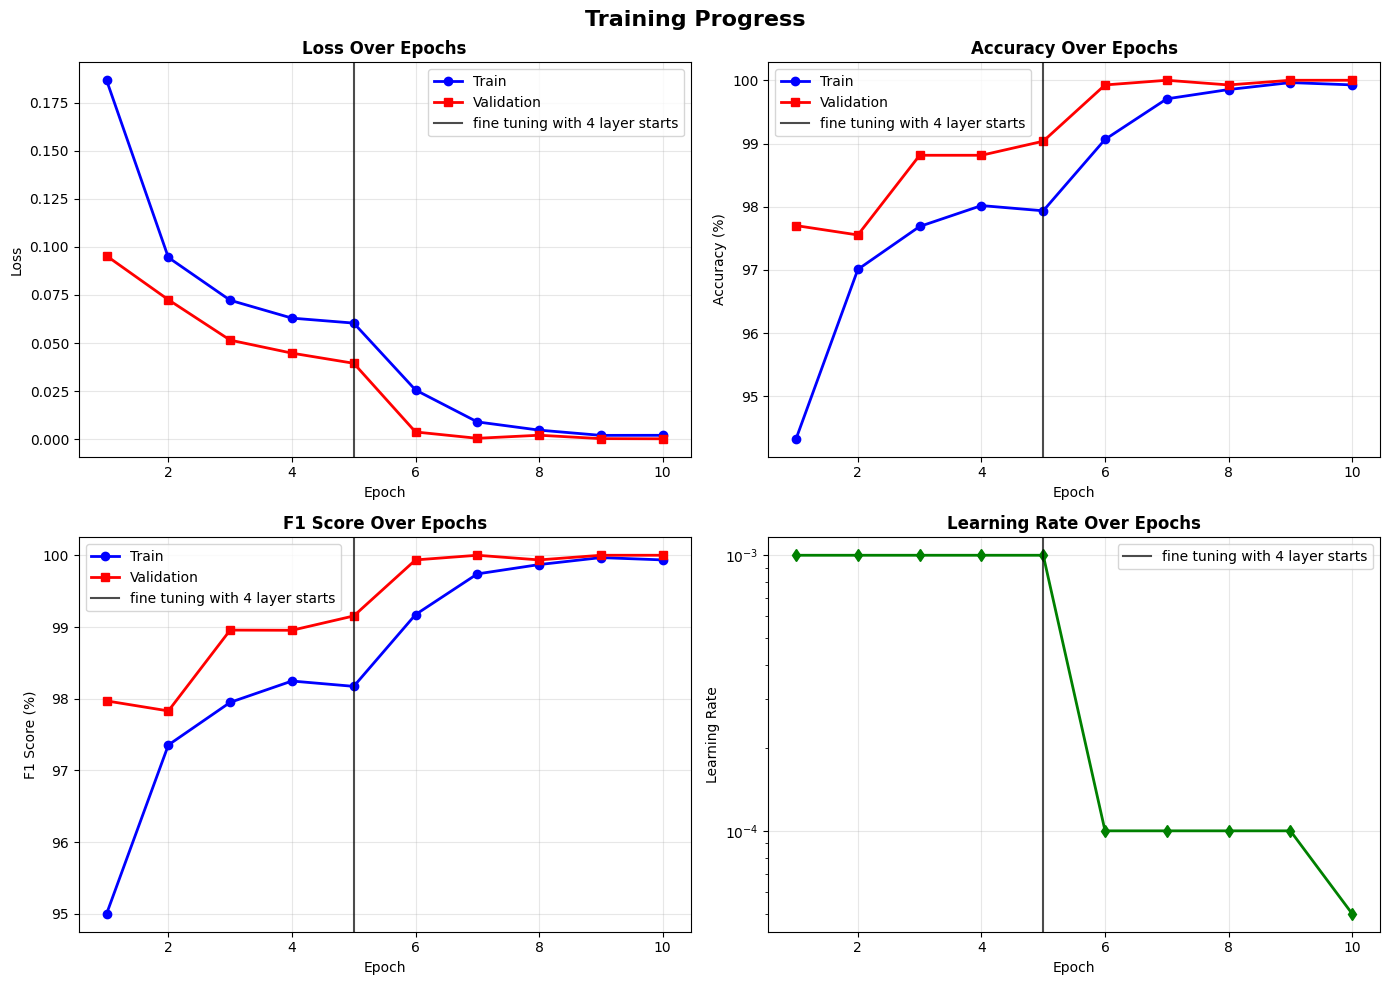

In [ ]:
#train validation plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs = history['epoch']
phase_change = EPOCHS_PHASE1

# Loss
axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2, marker='o')
axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2, marker='s')
axes[0, 0].axvline(x=phase_change, color='black', linestyle='-', label='fine tuning with 4 layer starts', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss Over Epochs', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(epochs, [x*100 for x in history['train_acc']], 'b-', label='Train', linewidth=2, marker='o')
axes[0, 1].plot(epochs, [x*100 for x in history['val_acc']], 'r-', label='Validation', linewidth=2, marker='s')
axes[0, 1].axvline(x=phase_change, color='black', linestyle='-', label='fine tuning with 4 layer starts', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Accuracy Over Epochs', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 Score
axes[1, 0].plot(epochs, [x*100 for x in history['train_f1']], 'b-', label='Train', linewidth=2, marker='o')
axes[1, 0].plot(epochs, [x*100 for x in history['val_f1']], 'r-', label='Validation', linewidth=2, marker='s')
axes[1, 0].axvline(x=phase_change, color='black', linestyle='-', label='fine tuning with 4 layer starts', alpha=0.7)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score (%)')
axes[1, 0].set_title('F1 Score Over Epochs', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
axes[1, 1].plot(epochs, history['lr'], 'g-', linewidth=2, marker='d')
axes[1, 1].axvline(x=phase_change, color='black', linestyle='-', label='fine tuning with 4 layer starts', alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Over Epochs', fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Training Progress', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.12 Evaluate on Kaggle Test Set

In [ ]:

kaggle_metrics, kaggle_labels, kaggle_preds, kaggle_probs = evaluate(model, kaggle_test_loader, criterion)

print(f"\n  Samples: {len(kaggle_labels)}")
print(f"  Accuracy:  {kaggle_metrics['accuracy']*100:.2f}%")
print(f"  Precision: {kaggle_metrics['precision']*100:.2f}%")
print(f"  Recall:    {kaggle_metrics['recall']*100:.2f}%")
print(f"  F1-Score:  {kaggle_metrics['f1']*100:.2f}%")
print(f"\n  Confusion Matrix:")
print(f"    TP: {kaggle_metrics['TP']}  |  FN: {kaggle_metrics['FN']}")
print(f"    FP: {kaggle_metrics['FP']}  |  TN: {kaggle_metrics['TN']}")


  Samples: 1349
  Accuracy:  100.00%
  Precision: 100.00%
  Recall:    100.00%
  F1-Score:  100.00%

  Confusion Matrix:
    TP: 763  |  FN: 0
    FP: 0  |  TN: 586


## 3.13 Evaluate on Drive Test Set

In [ ]:

# Copy to local for speed
LOCAL_TEST_DIR = "/content/tests_local"
if os.path.exists(LOCAL_TEST_DIR):
    shutil.rmtree(LOCAL_TEST_DIR)

print(f"\nCopying from Drive to local...")
!rsync -a --info=progress2 "{DRIVE_TEST_DIR}/" "{LOCAL_TEST_DIR}/"
print("Done")

# Create dataset and loader
drive_test_dataset = FreshRottenDataset(LOCAL_TEST_DIR, transform=val_transforms)
drive_test_loader = DataLoader(drive_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nDrive test samples: {len(drive_test_dataset)}")

# Evaluate
drive_metrics, drive_labels, drive_preds, drive_probs = evaluate(model, drive_test_loader, criterion)

print(f"\n  Accuracy:  {drive_metrics['accuracy']*100:.2f}%")
print(f"  Precision: {drive_metrics['precision']*100:.2f}%")
print(f"  Recall:    {drive_metrics['recall']*100:.2f}%")
print(f"  F1-Score:  {drive_metrics['f1']*100:.2f}%")
print(f"\n  Confusion Matrix:")
print(f"    TP: {drive_metrics['TP']}  |  FN: {drive_metrics['FN']}")
print(f"    FP: {drive_metrics['FP']}  |  TN: {drive_metrics['TN']}")


Copying from Drive to local...
  1,212,615,636 100%   82.27MB/s    0:00:14 (xfr#1200, to-chk=0/1207)
Done!

Drive test samples: 1200

  Accuracy:  77.42%
  Precision: 72.26%
  Recall:    89.00%
  F1-Score:  79.76%

  Confusion Matrix:
    TP: 534  |  FN: 66
    FP: 205  |  TN: 395


## 3.14 Confusion Matrices Heatmaps

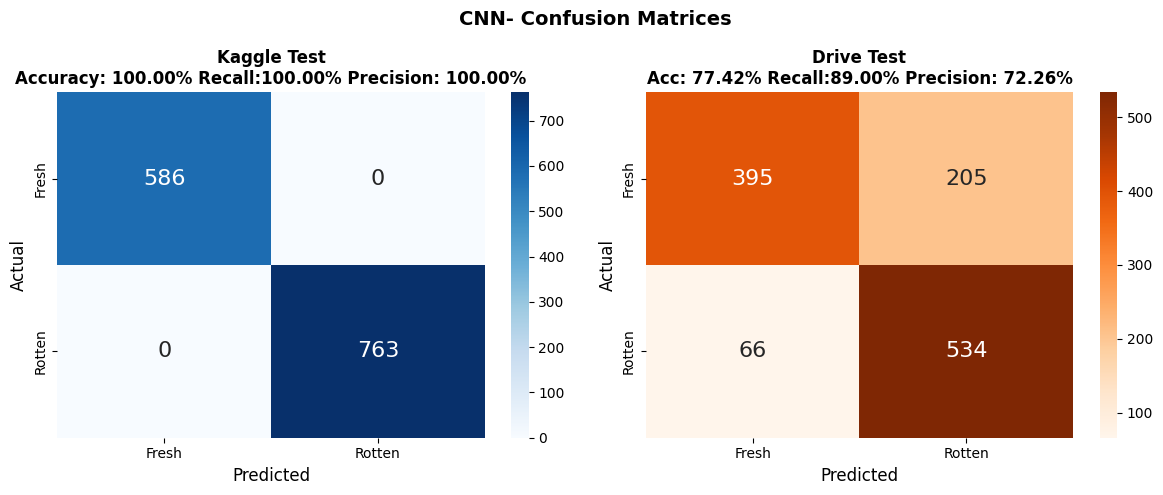

In [ ]:

#ploting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Kaggle confusion matrix
cm_kaggle = np.array([[kaggle_metrics['TN'], kaggle_metrics['FP']],
                      [kaggle_metrics['FN'], kaggle_metrics['TP']]])

sns.heatmap(cm_kaggle, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Fresh', 'Rotten'], yticklabels=['Fresh', 'Rotten'],
            annot_kws={'size': 16})
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title(f'Kaggle Test\nAccuracy: {kaggle_metrics["accuracy"]*100:.2f}% Recall:{kaggle_metrics["recall"]*100:.2f}% Precision: {kaggle_metrics["precision"]*100:.2f}%', fontweight='bold')

# Drive confusion matrix
cm_drive = np.array([[drive_metrics['TN'], drive_metrics['FP']],
                     [drive_metrics['FN'], drive_metrics['TP']]])

sns.heatmap(cm_drive, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Fresh', 'Rotten'], yticklabels=['Fresh', 'Rotten'],
            annot_kws={'size': 16})
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title(f'Drive Test\nAcc: {drive_metrics["accuracy"]*100:.2f}% Recall:{drive_metrics["recall"]*100:.2f}% Precision: {drive_metrics["precision"]*100:.2f}%', fontweight='bold')

plt.suptitle('CNN- Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.15 Sample Predictions Visualization

Kaggle Test Samples:


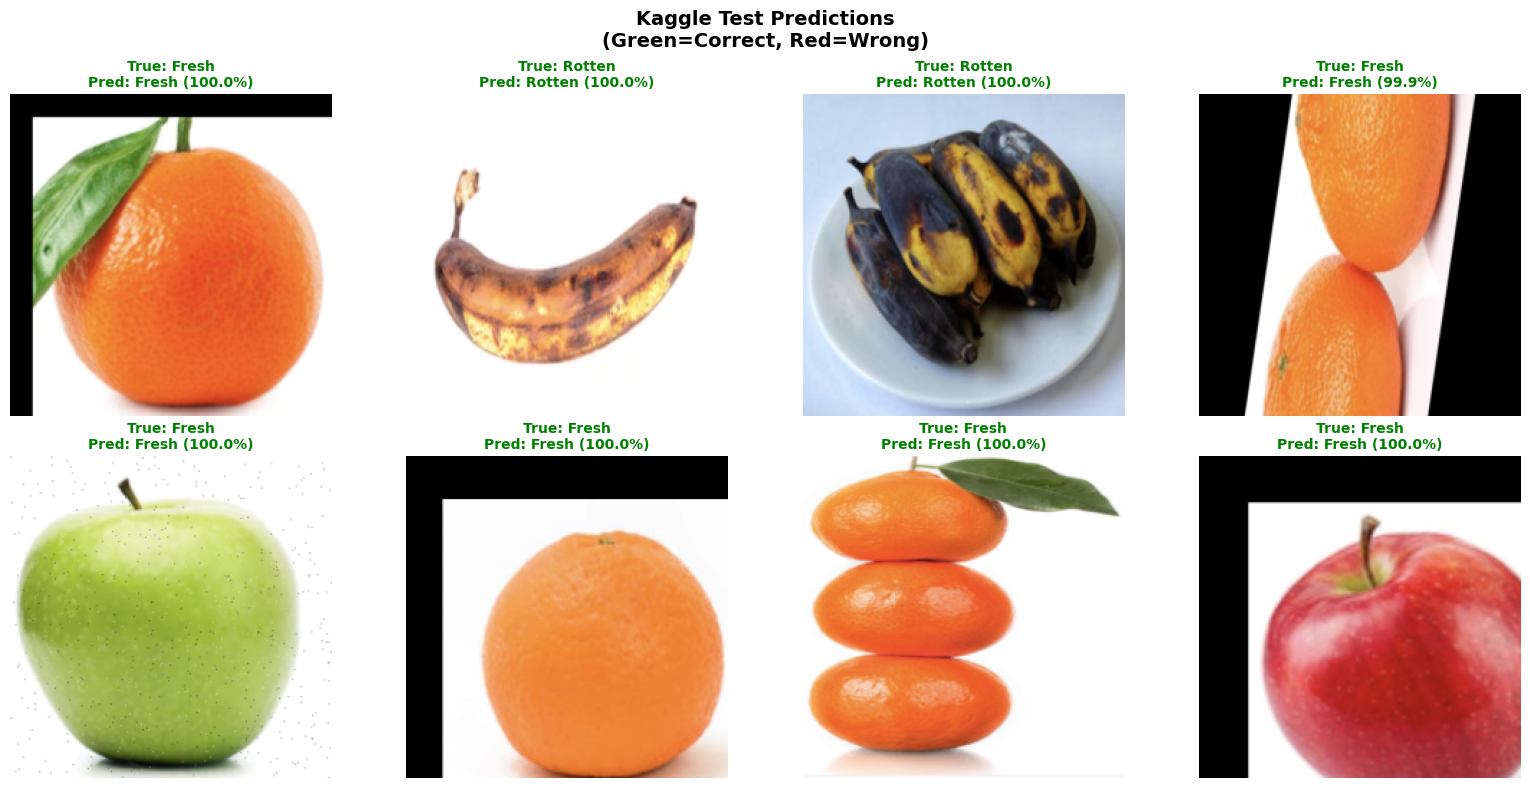


Drive Test Samples:


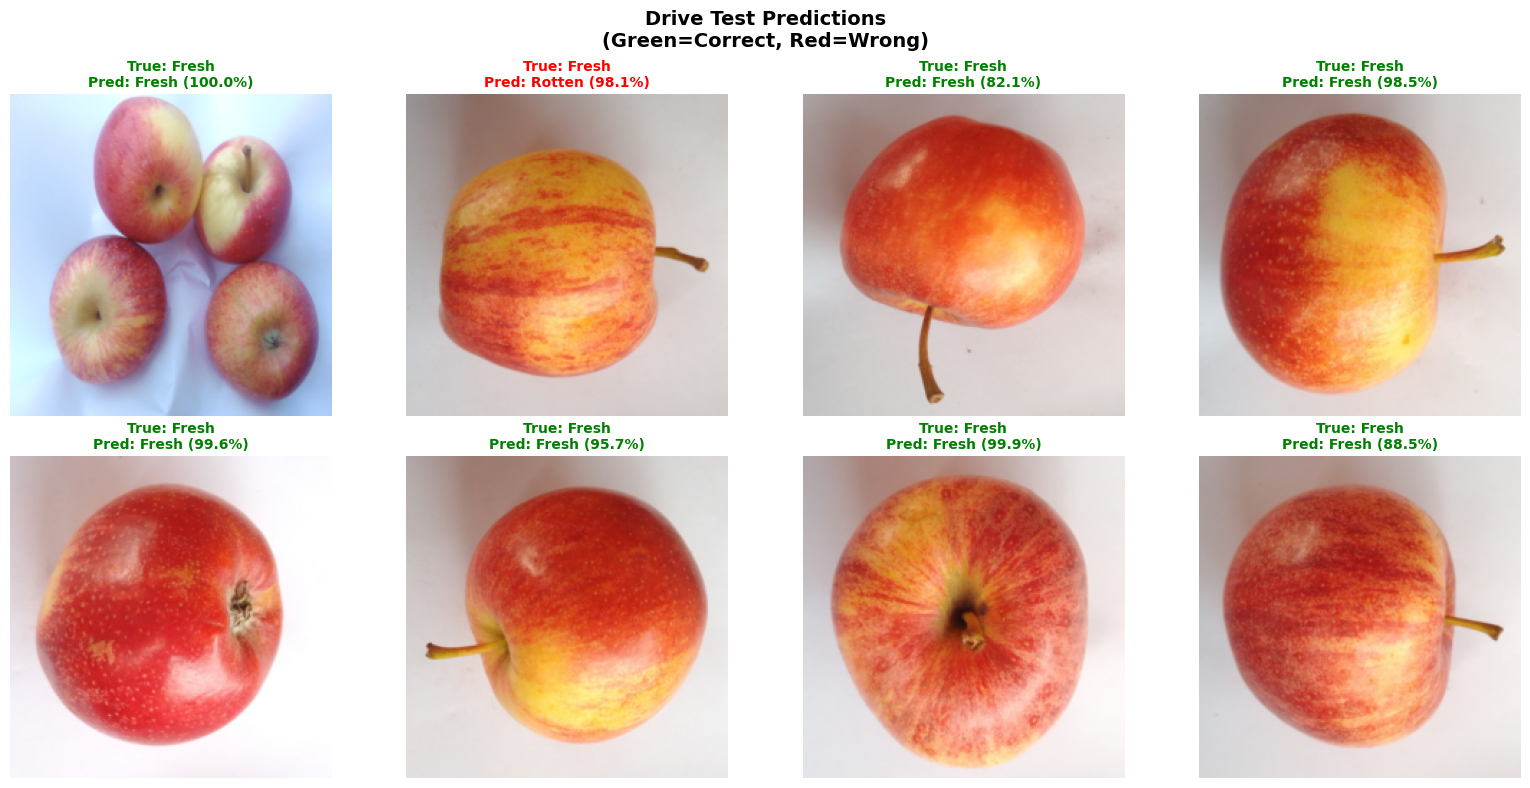

In [ ]:
# Show sample predictions with confidence
def show_predictions(loader, labels_list, preds_list, probs_list, title, n_samples=8):

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    # Get images
    images, true_labels = next(iter(loader))

    with torch.no_grad():
        outputs = model(images[:n_samples].to(device))
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

    class_names = ['Fresh', 'Rotten']

    for i in range(min(n_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        true_label = true_labels[i].item()
        pred_label = preds[i].item()
        confidence = probs[i, pred_label].item() * 100

        axes[i].imshow(img)

        correct = true_label == pred_label
        color = 'green' if correct else 'red'

        axes[i].set_title(f'True: {class_names[true_label]}\n'
                          f'Pred: {class_names[pred_label]} ({confidence:.1f}%)',
                          color=color, fontsize=10, fontweight='bold')
        axes[i].axis('off')

    plt.suptitle(f'{title}\n(Green=Correct, Red=Wrong)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show predictions
print("Kaggle Test Samples:")
show_predictions(kaggle_test_loader, kaggle_labels, kaggle_preds, kaggle_probs, "Kaggle Test Predictions")

print("\nDrive Test Samples:")
show_predictions(drive_test_loader, drive_labels, drive_preds, drive_probs, "Drive Test Predictions")

## 3.16 Save Model to Drive

In [ ]:

#Save model best weights to drive for future use

SAVE_DIR = "/content/drive/MyDrive/71254_2026/02_Assignment_Submission/omri.booton/projects"
os.makedirs(SAVE_DIR, exist_ok=True)

save_path = os.path.join(SAVE_DIR, "model_best.pth")

torch.save({
    'model_state_dict': model.state_dict(),
    'best_val_f1': best_val_f1,
    'kaggle_test_metrics': kaggle_metrics,
    'drive_test_metrics': drive_metrics,
    'history': history,
}, save_path)

print(f"Model saved to: {save_path}")

Model saved to: /content/drive/MyDrive/71254_2026/02_Assignment_Submission/omri.booton/projects/model_best.pth


## 3.17 Per Fruit Evaluation

In [ ]:
#Define Per Fruit Evaluation Function

def evaluate_resnet_per_fruit(model, base_dir, transform, device):
    model.eval()
    results = {}

    for fruit in ['apples', 'bananas', 'oranges']:
        all_preds = []
        all_labels = []

        for folder in os.listdir(base_dir):
            # Match fruit type (e.g., 'apple' in 'freshapples' or 'rottenapples')
            if fruit[:-1] not in folder.lower():
                continue

            folder_path = os.path.join(base_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            # Determine label: 1 = rotten, 0 = fresh
            label = 1 if 'rotten' in folder.lower() else 0

            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(folder_path, img_name)
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img_tensor = transform(img).unsqueeze(0).to(device)

                        with torch.no_grad():
                            output = model(img_tensor)
                            pred = output.argmax(dim=1).item()

                        all_preds.append(pred)
                        all_labels.append(label)
                    except Exception as e:
                        continue

        if len(all_labels) == 0:
            print(f"  Warning: No images found for {fruit}")
            continue

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # Calculate confusion matrix values
        tp = ((all_preds == 1) & (all_labels == 1)).sum()
        tn = ((all_preds == 0) & (all_labels == 0)).sum()
        fp = ((all_preds == 1) & (all_labels == 0)).sum()
        fn = ((all_preds == 0) & (all_labels == 1)).sum()

        # Calculate metrics
        accuracy = (tp + tn) / len(all_labels)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        results[fruit] = {
            'samples': len(all_labels),
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn)
        }

        print(f"  {fruit.capitalize()}: {len(all_labels)} images - Acc: {accuracy*100:.2f}%, F1: {f1*100:.2f}%")

    return results


# Run PerFruit Evaluation kaggle and drive

kaggle_per_fruit = evaluate_resnet_per_fruit(model, test_dir, val_transforms, device)

drive_per_fruit = evaluate_resnet_per_fruit(model, DRIVE_TEST_DIR, val_transforms, device)

# Results
rows = []
for fruit in ['apples', 'bananas', 'oranges']:
    if fruit in kaggle_per_fruit:
        k = kaggle_per_fruit[fruit]
        rows.append({
            'Fruit': fruit.capitalize(), 'Dataset': 'Kaggle', 'Samples': k['samples'],
            'Accuracy': f"{k['accuracy']*100:.2f}%", 'Precision': f"{k['precision']*100:.2f}%",
            'Recall': f"{k['recall']*100:.2f}%", 'F1': f"{k['f1']*100:.2f}%",
            'TP': k['TP'], 'TN': k['TN'], 'FP': k['FP'], 'FN': k['FN']
        })
    if fruit in drive_per_fruit:
        d = drive_per_fruit[fruit]
        rows.append({
            'Fruit': fruit.capitalize(), 'Dataset': 'Drive', 'Samples': d['samples'],
            'Accuracy': f"{d['accuracy']*100:.2f}%", 'Precision': f"{d['precision']*100:.2f}%",
            'Recall': f"{d['recall']*100:.2f}%", 'F1': f"{d['f1']*100:.2f}%",
            'TP': d['TP'], 'TN': d['TN'], 'FP': d['FP'], 'FN': d['FN']
        })

per_fruit_df = pd.DataFrame(rows)
print("\n" + per_fruit_df.to_string(index=False))

# Summary comparison table
summary_rows = []
for fruit in ['apples', 'bananas', 'oranges']:
    row = {'Fruit': fruit.capitalize()}
    if fruit in kaggle_per_fruit:
        row['Kaggle Acc'] = f"{kaggle_per_fruit[fruit]['accuracy']*100:.1f}%"
        row['Kaggle F1'] = f"{kaggle_per_fruit[fruit]['f1']*100:.1f}%"
    if fruit in drive_per_fruit:
        row['Drive Acc'] = f"{drive_per_fruit[fruit]['accuracy']*100:.1f}%"
        row['Drive F1'] = f"{drive_per_fruit[fruit]['f1']*100:.1f}%"
        if fruit in kaggle_per_fruit:
            diff = (drive_per_fruit[fruit]['accuracy'] - kaggle_per_fruit[fruit]['accuracy']) * 100
            row['Acc Diff'] = f"{diff:+.1f}%"
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("\n" + summary_df.to_string(index=False))


  Apples: 996 images - Acc: 100.00%, F1: 100.00%
  Bananas: 911 images - Acc: 100.00%, F1: 100.00%
  Oranges: 791 images - Acc: 100.00%, F1: 100.00%
  Apples: 400 images - Acc: 82.50%, F1: 82.23%
  Bananas: 400 images - Acc: 70.50%, F1: 77.22%
  Oranges: 400 images - Acc: 79.25%, F1: 80.56%

  Fruit Dataset  Samples Accuracy Precision  Recall      F1  TP  TN  FP  FN
 Apples  Kaggle      996  100.00%   100.00% 100.00% 100.00% 601 395   0   0
 Apples   Drive      400   82.50%    83.51%  81.00%  82.23% 162 168  32  38
Bananas  Kaggle      911  100.00%   100.00% 100.00% 100.00% 530 381   0   0
Bananas   Drive      400   70.50%    62.89% 100.00%  77.22% 200  82 118   0
Oranges  Kaggle      791  100.00%   100.00% 100.00% 100.00% 403 388   0   0
Oranges   Drive      400   79.25%    75.77%  86.00%  80.56% 172 145  55  28

  Fruit Kaggle Acc Kaggle F1 Drive Acc Drive F1 Acc Diff
 Apples     100.0%    100.0%     82.5%    82.2%   -17.5%
Bananas     100.0%    100.0%     70.5%    77.2%   -29.5%
Ora


#  Section 4: Final Comparison


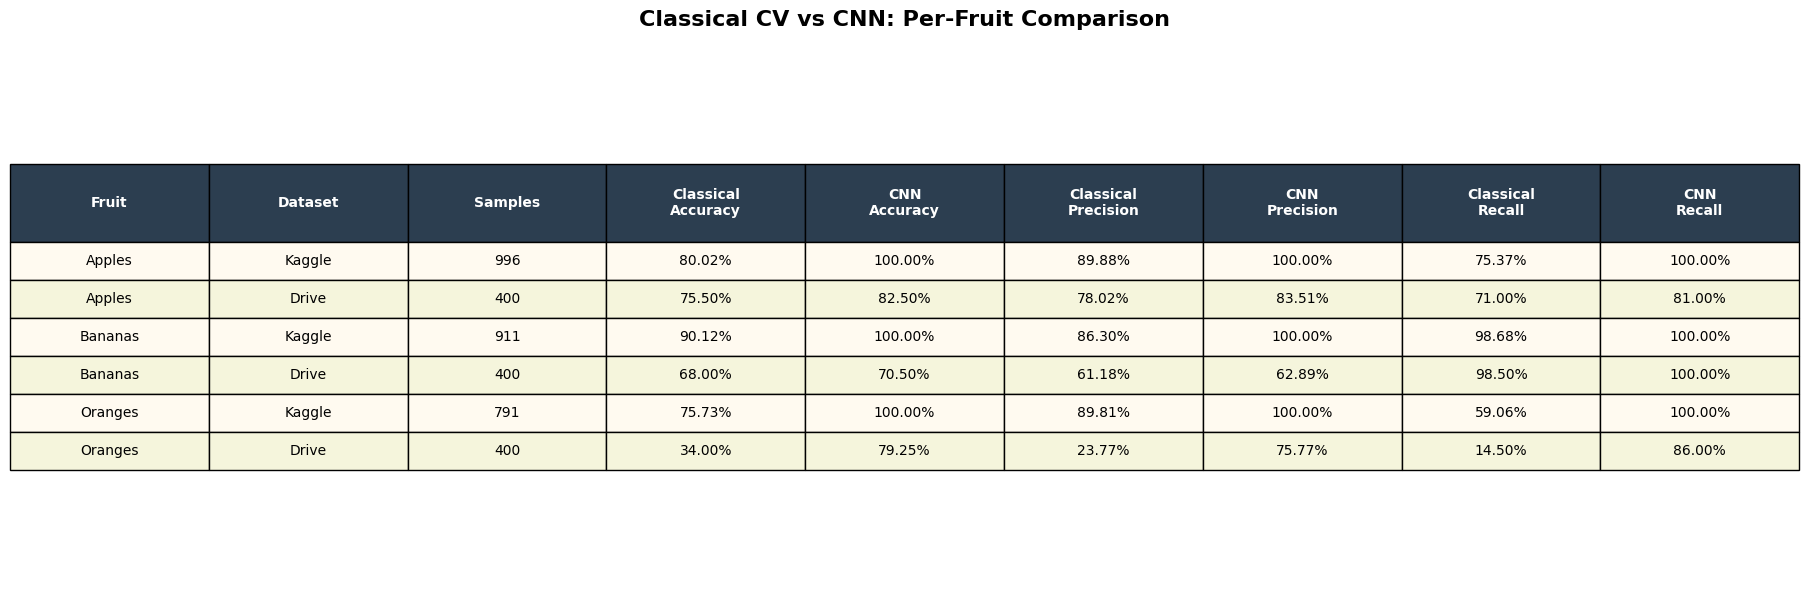

In [ ]:

# Combined Comparison Table: Classical CV vs CNN (Per Fruit)

# Build the combined table
comparison_rows = []

for fruit in ['apples', 'bananas', 'oranges']:
    # Kaggle row
    if fruit in kaggle_results and fruit in kaggle_per_fruit:
        classical_acc = kaggle_results[fruit]['accuracy'] * 100
        classical_precision = kaggle_results[fruit]['precision'] * 100
        classical_recall = kaggle_results[fruit]['recall'] * 100
        cnn_acc = kaggle_per_fruit[fruit]['accuracy'] * 100
        cnn_precision = kaggle_per_fruit[fruit]['precision'] * 100
        cnn_recall = kaggle_per_fruit[fruit]['recall'] * 100
        samples = kaggle_per_fruit[fruit]['samples']

        comparison_rows.append({
            'Fruit': fruit.capitalize(),
            'Dataset': 'Kaggle',
            'Samples': samples,
            'Classical\nAccuracy': f"{classical_acc:.2f}%",
            'CNN\nAccuracy': f"{cnn_acc:.2f}%",
            'Classical\nPrecision': f"{classical_precision:.2f}%",
            'CNN\nPrecision': f"{cnn_precision:.2f}%",
            'Classical\nRecall': f"{classical_recall:.2f}%",
            'CNN\nRecall': f"{cnn_recall:.2f}%"
        })

    # Drive row
    if fruit in drive_results and fruit in drive_per_fruit:
        classical_acc = drive_results[fruit]['accuracy'] * 100
        classical_precision = drive_results[fruit]['precision'] * 100
        classical_recall = drive_results[fruit]['recall'] * 100
        cnn_acc = drive_per_fruit[fruit]['accuracy'] * 100
        cnn_precision = drive_per_fruit[fruit]['precision'] * 100
        cnn_recall = drive_per_fruit[fruit]['recall'] * 100
        samples = drive_per_fruit[fruit]['samples']

        comparison_rows.append({
            'Fruit': fruit.capitalize(),
            'Dataset': 'Drive',
            'Samples': samples,
            'Classical\nAccuracy': f"{classical_acc:.2f}%",
            'CNN\nAccuracy': f"{cnn_acc:.2f}%",
            'Classical\nPrecision': f"{classical_precision:.2f}%",
            'CNN\nPrecision': f"{cnn_precision:.2f}%",
            'Classical\nRecall': f"{classical_recall:.2f}%",
            'CNN\nRecall': f"{cnn_recall:.2f}%"
        })

comparison_df = pd.DataFrame(comparison_rows)

# Create figure
fig, ax = plt.subplots(figsize=(18, 6))
ax.axis('off')

# Create table
table = ax.table(
    cellText=comparison_df.values,
    colLabels=comparison_df.columns,
    cellLoc='center',
    loc='center',
    colColours=['#2c3e50'] * len(comparison_df.columns)
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Style header row
for j, col in enumerate(comparison_df.columns):
    table[(0, j)].set_text_props(weight='bold', color='white')
    table[(0, j)].set_facecolor('#2c3e50')
    table[(0, j)].set_height(0.15)

# Style data rows
for i in range(1, len(comparison_df) + 1):
    for j in range(len(comparison_df.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f5f5dc')
        else:
            table[(i, j)].set_facecolor('#fffaf0')

plt.title('Classical CV vs CNN: Per-Fruit Comparison', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('comparison_table.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()